<a href="https://colab.research.google.com/github/timmmariya/Empirical-Law-Studies/blob/main/6_%D0%A1%D1%82%D0%B0%D1%86%D0%B8%D0%BE%D0%BD%D0%B0%D1%80%D0%BD%D0%BE%D1%81%D1%82%D1%8C%2C_%D0%BC%D0%BE%D0%B4%D0%B5%D0%BB%D1%8C_ARIMA_ipynb%22.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Представленный Colab Notebook является частью серии наработок по исследованиям в области практической оценки судопроизводства методами численного анализа, проводимых [НУЛ анализа данных правоприменения НИУ ВШЭ](https://adp.hse.ru/). 

Контактная информация рабочей группы: gkrasnozhenov@hse.ru (Григорий Григорьевич Красноженов, ЗавЛаб НУЛ АДП), timmariya541@gmail.com (Мария Тимонина, стажер, ответственный за текущую задачу)

Материалом для анализа служат **данные системы арбитражных судов РФ**.

---


***Hoping that Next paragraph will come true soon...***

На более ранних этапах исследования осуществлена первичная очистка данных. Далее с целью оптимизации обработки блоков базы, относящихся к отдельным временным рядам, строки отсортированы согласно введенной классификации по списку значимых признаков.


#### Реализуем стандартный пролог - подключим библиотеки и загрузим ряды из [предыдущей Colab Notebook](https://colab.research.google.com/drive/1CYFUJqPkxxQXzSjwMtgDms8iD6pHpCbs?usp=sharing)

In [ ]:
import numpy as np        
import pandas as pd  
from scipy import stats
from matplotlib import colors

import statsmodels.api as sm
from statsmodels.iolib.table import SimpleTable
from sklearn.metrics import r2_score

#библиотеки для визуализации
import matplotlib.pyplot as plt
import seaborn as sns

plt.style.use('ggplot') # стиль графиков
%matplotlib inline

In [ ]:
from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


In [ ]:
ts1 =  pd.read_csv("/content/drive/MyDrive/НУЛ АДП Материалы Марии Тимониной/_data/TimeSeries1.csv", sep=',', index_col=0)
ts1.index = pd.to_datetime(ts1.index)

ts2 =  pd.read_csv("/content/drive/MyDrive/НУЛ АДП Материалы Марии Тимониной/_data/TimeSeries2.csv", sep=',', index_col=0)
ts2.index = pd.to_datetime(ts2.index)

ts3 =  pd.read_csv("/content/drive/MyDrive/НУЛ АДП Материалы Марии Тимониной/_data/TimeSeries3.csv", sep=',', index_col=0)
ts3.index = pd.to_datetime(ts3.index)

ts4 =  pd.read_csv("/content/drive/MyDrive/НУЛ АДП Материалы Марии Тимониной/_data/TimeSeries4.csv", sep=',', index_col=0)
ts4.index = pd.to_datetime(ts4.index)

ts5 =  pd.read_csv("/content/drive/MyDrive/НУЛ АДП Материалы Марии Тимониной/_data/TimeSeries5.csv", sep=',', index_col=0)
ts5.index = pd.to_datetime(ts5.index)


# **Постановка задачи**

Для предсказуемости поведения модели следует наложить на ряд требование иметь свойство неизменяемости своих характеристик с течением времени – **стационарность**. 

Временной ряд $y(t)$ называется строго стационарным, если совместное распределение $m$ наблюдений $y(t_1), y(t_2), …, y(t_m)$ не зависит от изменения времени. Ряд является слабо стационарным («стационарным в широком смысле») при выполнении следующих условий:
*	математическое ожидание $E(y_t) = E(y_{t+1}) = … = E(y_{t+k}) = …$
*	дисперсия $D(y_t) = D(y_{t+1}) = … = D(y_{t+k}) = …$
*	автоковариационная функция $Cov(y_t, y_{t+k})$

не зависимы от временного момента $t$ для любого значения сдвига $k$. В общепринятой практике прикладной работы с временными рядами применяется второе определение, и в данном исследовании понятие стационарности будет использоваться именно в таком понимании.


---


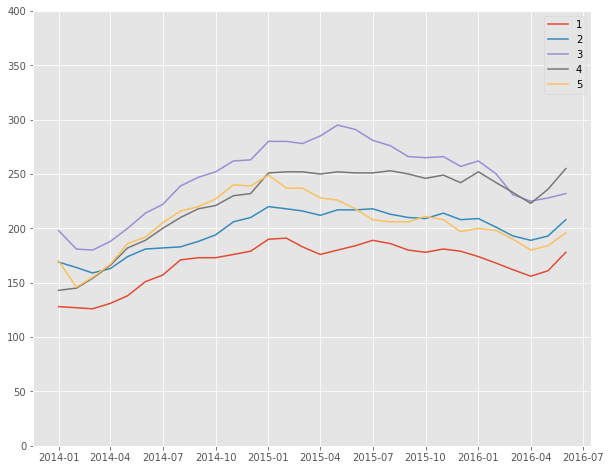

In [ ]:
plt.figure(figsize=(10,8))

plt.plot(ts1)
plt.plot(ts2)
plt.plot(ts3)
plt.plot(ts4)
plt.plot(ts5)

plt.ylim(0, 400)
plt.legend(['1', '2', '3', '4', '5'])
plt.show()

# **Основная часть**

## **Стационарность**

Для проверки проверки стационарности давайте проведем обобщенный **тест Дикки-Фуллера** на наличие единичных корней.

In [ ]:
def stationarity_adfuller_check(timeseries, draw):
    import matplotlib.pyplot as plt
    from statsmodels.tsa.stattools import adfuller
    
    #Расчет скользящего среднего
    rolmean = timeseries.rolling(4).mean()
    rolstd = timeseries.rolling(4).std()

    #Добавление визуализации на график
    plt.figure(figsize=(10,6))
    orig = plt.plot(timeseries, color='blue',label='Original')
    if draw :
        mean = plt.plot(rolmean, color='red', label='Rolling Mean')
        std = plt.plot(rolstd, color='black', label = 'Rolling Std')
    plt.legend(loc='best')
    plt.title('Скользящее Среднее и стандартное отклонение')
    plt.show(block=False)
    
    #Perform Dickey-Fuller test:
    print('Результаты теста Дики-Фуллера:')
    data1 = timeseries.iloc[:,0].values
    dftest = adfuller(data1, autolag='AIC')
    dfoutput = pd.Series(dftest[0:4], index=['Статистика','p-value','#Lags Used','Число наблюдений'])
    for key,value in dftest[4].items():
        dfoutput['Критическое значение (%s)'%key] = value
    print(dfoutput)
    if (dftest[0]> dftest[4]['5%']) : 
        print('\nЕсть единичные корни, ряд не стационарен')
    else:
        print('\nЕдиничных корней нет, ряд стационарен')

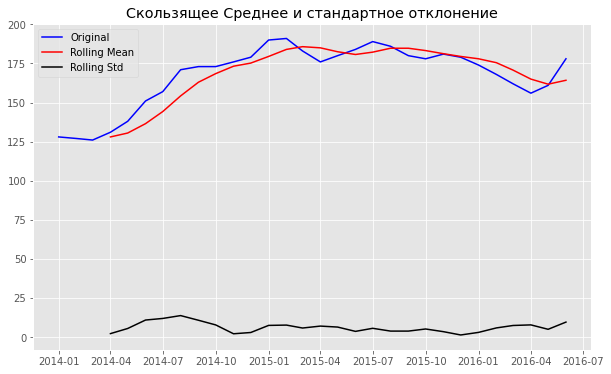

Результаты теста Дики-Фуллера:
Статистика                    -2.474824
p-value                        0.121721
#Lags Used                     1.000000
Число наблюдений              28.000000
Критическое значение (1%)     -3.688926
Критическое значение (5%)     -2.971989
Критическое значение (10%)    -2.625296
dtype: float64

Есть единичные корни, ряд не стационарен


In [ ]:
test_stationarity(ts1, 1)

## Приведение ряда к стационарному

Попробуем вычесть скользящее среднее, чтобы сгладить изгиб.

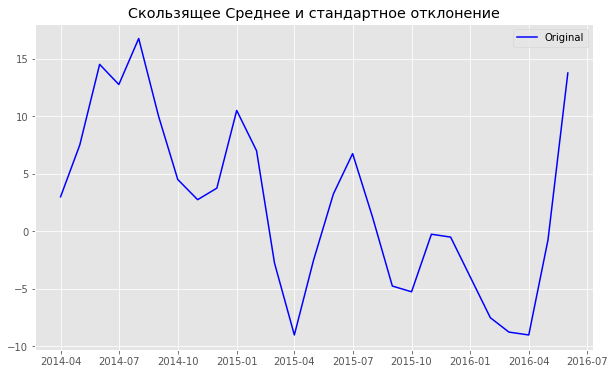

Результаты теста Дики-Фуллера:
Статистика                    -3.010849
p-value                        0.033894
#Lags Used                     1.000000
Число наблюдений              25.000000
Критическое значение (1%)     -3.723863
Критическое значение (5%)     -2.986489
Критическое значение (10%)    -2.632800
dtype: float64

Единичных корней нет, ряд стационарен


In [ ]:
moving_avg = ts1.rolling(4).mean()

ts_moving_avg_diff = ts1 - moving_avg
ts_moving_avg_diff.dropna(inplace=True)
test_stationarity(ts_moving_avg_diff, 0)

## Компонентный анализ

Питон умеет так: https://www.analyticsvidhya.com/blog/2016/02/time-series-forecasting-codes-python/

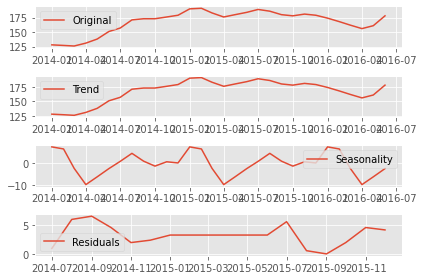

In [ ]:
from statsmodels.tsa.seasonal import seasonal_decompose
decomposition = seasonal_decompose(ts1)

trend = decomposition.trend
seasonal = decomposition.seasonal
residual = decomposition.resid

plt.subplot(411)
plt.plot(ts1, label='Original')
plt.legend(loc='best')
plt.subplot(412)
plt.plot(ts1, label='Trend')
plt.legend(loc='best')
plt.subplot(413)
plt.plot(seasonal,label='Seasonality')
plt.legend(loc='best')
plt.subplot(414)
plt.plot(residual, label='Residuals')
plt.legend(loc='best')
plt.tight_layout()

Хотим делать в более ручном осознанном режиме https://habr.com/ru/post/207160/